In [1]:
from sage.all import *

In [2]:
ring = PolynomialRing(QQ, ('x', 'y'), order='degrevlex')
x, y = ring.gens()

In [7]:
def border(O):
    gens = O[0].args()
    B = []
    for x in gens:
        B += [x*o for o in O if x*o not in O]
    return sorted(list(set(B)), key=lambda t: t)

def terms_up_to_degree(d: int, ring):
    """Compute all terms up to degree d."""
    n = ring.ngens()
    terms = [ring(1)]
    for t in range(1, d+1):
        exponents = list(WeightedIntegerVectors(t, [1]*n))
        terms.extend([ring.monomial(*e) for e in exponents])
        
    terms = sorted(terms, key=lambda t: t)
    return terms

def order_from_border(B, ring):
    max_deg = max([b.degree() for b in B])
    terms = terms_up_to_degree(max_deg, ring)
    O = []
    for t in terms:
        if any([t.divides(b) for b in B if t != b]):
            O.append(t)
            
    return O

def subs(F, P):
    '''
    F: list of polynomials
    P: list of points
    '''
    field = P[0, 0].base_ring()
    num_polys  = len(F)
    num_points = P.nrows()
    
    FP = [f(*p) for f in F for p in P]

    return MatrixSpace(field, num_points, num_polys)(FP)

def is_regular(M):
    r = min(M.ncols(), M.nrows())
    return M.rank() == r

def keyword_for_numbound(field, bound):
    if field == QQ:
        return {'num_bound': bound}
    if field == ZZ:
        return {'x': -bound, 'y': bound}
    if field == RR:
        return {'min': -bound, 'max': bound}
    if field.is_finite():
        return {}
    

def is_all_divisors_in(t: Polynomial, O) -> bool:
    """
    Check if adding term t to order ideal O maintains the order ideal property.
    
    Since O is already an order ideal, we only need to check immediate divisors
    (reducing degree by 1 for each variable).
    """
    if t.degree() in (0, 1): 
        return True
    
    return all([xi in O and t/xi in O for xi in t.args() if xi.divides(t)])


def is_order_ideal(O):
    max_deg = max([o.degree() for o in O])
    
    if 1 not in O:
        return False
    
    O_ = [1]
    for d in range(1, max_deg+1):
        terms = [o for o in O if o.degree() == d]
        for t in terms:
            if not is_all_divisors_in(t, O_):
                return False
        
        O_ += terms
    
    return True
    
    

In [583]:
import itertools as it
from random import shuffle
import numpy as np
from copy import copy, deepcopy
from dataclasses import dataclass
from typing import List

def min_but_max_at_i(a, b, i):
    lb = np.minimum(a, b)
    lb[i] = max(a[i], b[i])
    return lb 

def max_but_min_at_i(a, b, i):
    ub = np.maximum(a, b)
    ub[i] = min(a[i], b[i])
    return ub 

def is_on_axis(v):
    return np.sum(v != 0) <= 1

@dataclass
class Segment():
    endpoints: tuple  # two endpoints (n-dim vector each)
    
    def __post_init__(self):
        self.lb = np.minimum.reduce(self.endpoints)
        self.ub = np.maximum.reduce(self.endpoints)
        self.n = len(self.lb)
    
    def __repr__(self):
        return f'Segment(lb={self.lb}, ub={self.ub}, endpoint={self.endpoints})'
    
    def sampling(self, exclude_axis=True, exclude_endpoints=True, exclude_vertices=True):
        while True:
            endpoint = np.random.randint(self.lb, self.ub+1)
            # endpoint = np.random.randint(self.lb+1, self.ub)
            if exclude_axis and is_on_axis(endpoint):
                # print('on axis!', endpoint)
                continue
            if exclude_endpoints and any([np.array_equal(endpoint, e) for e in self.endpoints]):
                # print('on endpoints!', endpoint)
                continue
            if exclude_vertices and all(endpoint[i] in (self.lb[i], self.ub[i]) for i in range(self.n)):
                # print('on vertices!', endpoint)
                continue
            # if endpoint[-1] == self.ub[-1]:
            #     if all([endpoint[i] in (self.lb[i], self.ub[i]) for i in range(self.n-1)]) and not np.array_equal(endpoint[:-1], self.lb[:-1]):
            #             continue
            
            break
        
        return endpoint
    
    def crack_at(self, crack_point):
        endpoints = [min_but_max_at_i(self.lb, self.ub, i) for i in range(self.n)]
        new_segments = [Segment(deepcopy([endpoint, crack_point])) for endpoint in endpoints]
        return new_segments    
        
    def regular_subsegment(self):
        '''
        remove degenrated dimension
        '''
        if not self.is_degenerated(): 
            return self
        else:
            valid_coordinates = self.lb < self.ub
            return Segment(deepcopy([endpoint[valid_coordinates] for endpoint in self.endpoints]))
        
    def is_degenerated(self):
        return any(self.lb == self.ub)
    
    def is_1dim(self):
        return (self.lb != self.ub).sum() == 1
    
    def is_unity(self):
        valid_coordinates = self.lb < self.ub
        return not any (valid_coordinates) or all(np.abs(self.lb[valid_coordinates] - self.ub[valid_coordinates]) == 1)
        # return any(np.abs(self.lb - self.ub) <= 2)
    
    
    # def is_crackable(self):
    #     is_unit_size = all(np.abs(self.lb - self.ub) <= 1)
    #     is_degenerated = any(self.lb == self.ub)
    #     return not is_unit_size and not is_degenerated


class BorderBasisGenerator():
    def __init__(self, ring): 
        self.ring = ring 
        self.n = ring.ngens()
        
    def find_random_border(self, degree_bounds, max_iters=100, preborder_size_limit=100):
        """
        ランダムなプレボーダーを生成
        
        Parameters:
        -----------
        degree_bounds: list of maximum degree for each variable
        max_iters: 最大反復回数
        preborder_size_limit: ボーダーの最大サイズ
        """
        if len(degree_bounds) != self.n:
            raise ValueError("Length of degree_bounds must be equal to the number of indeterminates.")
        
        E = list(np.eye(self.n, dtype=int) * np.array(degree_bounds, dtype=int))
        S = [Segment(E)]  # セグメントのリスト
        T = []
        trajectory = [deepcopy(E)]
        
        print('find preborder')
        
        for i in range(max_iters):
            if not S:
                print(f'No more segments to sample after {i} iterations.')
                break
            
            segment = S.pop(0)
            new_endpoint = segment.sampling()
            
            print()
            print('#### iteration:', i)
            print(f'segment: {segment}')
            print(f'new endpoint: {new_endpoint}')

            if (np.array_equal(new_endpoint, segment.ub) \
                or is_on_axis(new_endpoint) \
                or any([np.array_equal(new_endpoint, endpoint) for endpoint in E])):
                T.append(segment)
                
                print('max point or on axis or on segment endpoints')
                print(np.array_equal(new_endpoint, segment.ub))
                print(is_on_axis(new_endpoint))
                print([np.array_equal(new_endpoint, endpoint) for endpoint in E])
                
                continue
            
            new_segments = segment.crack_at(new_endpoint)
            
            got_noncrackable = False
            for new_segment in new_segments:
                if new_segment.is_unity():
                    T.append(new_segment)
                    got_noncrackable = True
                    print(f'new segment: {new_segment} is unit size.')
                    # E.extend(deepcopy(new_segment.endpoints))
                    # E.append(new_segment.endpoints[0])
                # elif new_segment.is_degenerated():
                # elif new_segment.is_1dim():
                    # T.append(new_segment)
                    got_noncrackable = True
                    # print(f'new segment: {new_segment} is degenerated.')
                else:
                    S.append(new_segment)
                    print(f'new segment: {new_segment} is crackable.')

                    # trajectory.append(deepcopy(E))
                    # print(f'new segment: {new_segment} is crackable.')
                    # got_noncrackable = True

            E.append(deepcopy(new_endpoint))
            trajectory.append(deepcopy(E))
            print('new endpoint added:', E)
                
            # T.extend([new_segment for new_segment in new_segments if new_segment.is_degenerated()])
            # S.extend([new_segment for new_segment in new_segments if not new_segment.is_degenerated()])
        
        print()
        print('Preborder is found')
        print('The segments are ')
        for t in T:
            print(t)
            
        plot_border_3d(degree_bounds, E) if self.n == 3 else plot_border(degree_bounds, E)
        
        print()
        print('---------------------------------')
        print('Spanning the border')
        B = self.span_border(T) + E[:self.n]
        
        # B = self.span_border(T) + E
        # trajectory.append(deepcopy(B))
        # # B = self.clean_up(B)
        plot_border_3d(degree_bounds, B) if self.n == 3 else plot_border(degree_bounds, B)
        # B = self.clean_axis_hyperplanes(B)
        # plot_border_3d(degree_bounds, B) if self.n == 3 else plot_border(degree_bounds, B)
        # # B = None
        # return {'border': B, 'endpoints': E, 'segments': T, 'trajectory': trajectory}
        
    def grid_points_on_max_faces(self, segment: Segment) -> np.ndarray:
        """
        セグメントの最大値の面上の点を生成
        """
        u = segment.lb
        v = segment.ub
        n = segment.n
        points = set()
        
        if n == 1:
            return np.arange(u[0], v[0]).reshape(-1, 1)  # exclude the upper bound (not v[0] + 1)

        # 各次元kについて
        for k in range(n):
                
            # k次元目が最大値の面上の点を生成
            grid_ranges = [range(u[i], v[i] + 1) for i in range(n)]
            grid_ranges[k] = [v[k]]  # k次元目は最大値で固定
            
            # この面上の点を生成
            for point in it.product(*grid_ranges):
                point = np.array(point)
                points.add(tuple(point))
        
        return np.array(list(points)) if points else np.array([])
    
    def clean_up(self, preborder: List):
        """
        プレボーダーをクリーンアップしてボーダーを生成
        """
        canoninal_basis = np.eye(self.n)
        
        preborder = np.array(preborder)
        border = []
        for pb in preborder:
            
            # is_border_of_border = [any(np.all(pb - canoninal_basis[j] == preborder, axis=-1)) for j in range(self.n)]
            is_inside_of_border = [any(np.all(pb + canoninal_basis[j] == preborder, axis=-1)) for j in range(self.n)]
            
            # is_corner = is_border_of_border.count(True) == self.n 
            # is_inner = is_inside_of_border.count(True) == self.n
            
                # print('border:', pb, is_border_of_border)
            # else:
                # print('not border:', pb)

            
            # if not any(pb == 0):
            #     border.append(pb)
            #     continue
            
            # for i in range(self.n):
            #     is_border = True
            #     if pb[i] == 0:
            #         has_senior = [any(np.all(pb + canoninal_basis[j] == preborder, axis=-1)) for j in range(self.n) if i != j]
            #         is_border = not any(has_senior)

            # if is_border:            
            #     border.append(pb)

        return border
    
    def clean_axis_hyperplanes(self, preborder):
        '''
        Remove unnecessary points from hyperplanes H_k = {x | x_k = 0}. 
        '''
        
        # print('\n\n\n\n preborder \n\n\n\n')
        # print(preborder)
        preborder = np.array(preborder)
        border = [p for p in preborder if not any(p == 0)]
        
        
        for k in range(self.n):
            preborder_k = preborder[preborder[:, k] == 0]
            for pb in preborder_k:
                # if there are some other guy greater than you in all aspects
                if not any(np.logical_and(np.all(preborder_k >= pb, axis=-1), ~np.all(preborder_k == pb, axis=-1))):
                    border.append(pb)
                    
        return border
    
    
    def at_up_corner(self, p, segment):
        lb, ub, n = segment.lb, segment.ub, segment.n
        
        if n == 1:
            return all(p == ub)
        
        if (p[-1] == ub[-1] \
            and all([p[i] in (lb[i], ub[i]) for i in range(n-1)]) \
            and not np.array_equal(p[:-1], lb[:-1])):
            return True
        else:
            return False

    # def sandpaper(self, spanned_border):
    #     max_values = np.max(np.array(spanned_border), axis=0)
    #     border = []
    #     for b in spanned_border:
            
        
    def span_border(self, T: List[Segment]) -> List[np.ndarray]:
        """複数のSegmentからボーダー点を生成"""
        
        print('span border')
        
        all_points = []
        for segment in T:
            print()
            print(f'segment: {segment}')
            
            if all(is_on_axis(ep) for ep in segment.endpoints):
                print('on axis')
                continue
            
            valid_coordinates = segment.lb < segment.ub
            print(f'valid_coordinates: {valid_coordinates}')
            rsegment = segment.regular_subsegment()
            sub_points = self.grid_points_on_max_faces(rsegment)
            
            print('max face points:', sub_points)
            
            points = [copy(segment.lb) for _ in sub_points]
            
            for i, sub_point in enumerate(sub_points):
                if not self.at_up_corner(sub_point, rsegment):
                    points[i][valid_coordinates] = sub_point
                    print('not at up corner:', sub_point, points[i])
                else:
                    print('at up corner:', sub_point)
            
            points = [p for p in points if not is_on_axis(p)]
            print('new points ', points)
            all_points.extend(deepcopy(points))
            # points = [p for p in ]
            # if not segment.is_degenerated():
            #     points = self.grid_points_on_max_faces(segment)
            #     at_up_corner = lambda p: p[-1] == segment.ub[-1] and all([p[i] in (segment.lb[i], segment.ub[i]) for i in range(segment.n-1)]) and not np.array_equal(p[:-1], segment.lb[:-1])
            #     points = [point for point in points if not at_up_corner(point)]
            
            # else:
            #     valid_coordinates = segment.lb < segment.ub
            #     sub_lb = segment.lb[valid_coordinates]
            #     sub_ub = segment.ub[valid_coordinates]
            #     sub_n = segment.n
            #     at_up_corner = lambda p: p[valid_coordinates][-1] == sub_ub[-1] and all([[valid_coordinates][i] in (sub_lb[i], sub_ub[i]) for i in range(sub_n)]) and not np.array_equal(p[valid_coordinates][:-1], segment.lb[:-1])

            # if len(points) > 0:
            #     all_points.extend(deepcopy(points))
            
        else:
            print('degenerated segment!')
        
        # max_points = [segment.ub for segment in T]
        # is_max_point = lambda p: any(np.array_equal(p, ub) for ub in max_points)
        # print(f'ubs: {max_points}')

        # all_points = np.unique(np.vstack(all_points), axis=0)
        # print('all points:', all_points)
        
        # for p in all_points:
        #     if is_max_point(p):
        #         print(p, is_max_point(p))

        # all_points = [point for point in all_points if not is_max_point(point)]
        
        if not all_points:
            return []
        
        # 重複を除去
        border = np.unique(np.vstack(all_points), axis=0)
        return border.tolist()



if __name__ == "__main__":
    # Usage example will go here
    pass

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.44 µs
find preborder

#### iteration: 0
segment: Segment(lb=[0 0], ub=[4 5], endpoint=[array([4, 0]), array([0, 5])])
new endpoint: [3 3]
new segment: Segment(lb=[3 0], ub=[4 3], endpoint=[array([4, 0]), array([3, 3])]) is crackable.
new segment: Segment(lb=[0 3], ub=[3 5], endpoint=[array([0, 5]), array([3, 3])]) is crackable.
new endpoint added: [array([4, 0]), array([0, 5]), array([3, 3])]

#### iteration: 1
segment: Segment(lb=[3 0], ub=[4 3], endpoint=[array([4, 0]), array([3, 3])])
new endpoint: [4 1]
new segment: Segment(lb=[4 0], ub=[4 1], endpoint=[array([4, 0]), array([4, 1])]) is unit size.
new segment: Segment(lb=[3 1], ub=[4 3], endpoint=[array([3, 3]), array([4, 1])]) is crackable.
new endpoint added: [array([4, 0]), array([0, 5]), array([3, 3]), array([4, 1])]

#### iteration: 2
segment: Segment(lb=[0 3], ub=[3 5], endpoint=[array([0, 5]), array([3, 3])])
new endpoint: [3 4]
new segment: Segment(lb=[3 3], ub=[

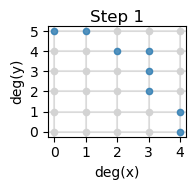


---------------------------------
Spanning the border
span border

segment: Segment(lb=[4 0], ub=[4 1], endpoint=[array([4, 0]), array([4, 1])])
valid_coordinates: [False  True]
max face points: [[0]]
not at up corner: [0] [4 0]
new points  []

segment: Segment(lb=[3 3], ub=[3 4], endpoint=[array([3, 3]), array([3, 4])])
valid_coordinates: [False  True]
max face points: [[3]]
not at up corner: [3] [3 3]
new points  [array([3, 3])]

segment: Segment(lb=[3 1], ub=[4 2], endpoint=[array([4, 1]), array([3, 2])])
valid_coordinates: [ True  True]
max face points: [[3 2]
 [4 1]
 [4 2]]
not at up corner: [3 2] [3 2]
not at up corner: [4 1] [4 1]
at up corner: [4 2]
new points  [array([3, 2]), array([4, 1]), array([3, 1])]

segment: Segment(lb=[3 2], ub=[3 3], endpoint=[array([3, 3]), array([3, 2])])
valid_coordinates: [False  True]
max face points: [[2]]
not at up corner: [2] [3 2]
new points  [array([3, 2])]

segment: Segment(lb=[0 5], ub=[1 5], endpoint=[array([0, 5]), array([1, 5])])
valid

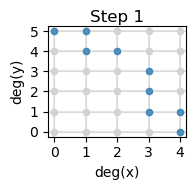

In [596]:
%time
seed = 0
np.random.seed(seed)
import random
random.seed(seed)

ring = PolynomialRing(QQ, ('x', 'y'), order='degrevlex')
generator = BorderBasisGenerator(ring)

dbounds = [4, 5]
ret = generator.find_random_border(dbounds, max_iters=10)

# borders = ret['trajectory'] + [ret['border']]
# # plot_borders(dbounds, borders)
# plot_border(dbounds, ret['endpoints'])
# plot_border(dbounds, ret['border'])

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 6.68 µs
find preborder

#### iteration: 0
segment: Segment(lb=[0 0 0], ub=[2 1 1], endpoint=[array([2, 0, 0]), array([0, 1, 0]), array([0, 0, 1])])
new endpoint: [1 1 1]
new segment: Segment(lb=[1 0 0], ub=[2 1 1], endpoint=[array([2, 0, 0]), array([1, 1, 1])]) is unit size.
new segment: Segment(lb=[0 1 0], ub=[1 1 1], endpoint=[array([0, 1, 0]), array([1, 1, 1])]) is unit size.
new segment: Segment(lb=[0 0 1], ub=[1 1 1], endpoint=[array([0, 0, 1]), array([1, 1, 1])]) is unit size.
new endpoint added: [array([2, 0, 0]), array([0, 1, 0]), array([0, 0, 1]), array([1, 1, 1])]
No more segments to sample after 1 iterations.

Preborder is found
The segments are 
Segment(lb=[1 0 0], ub=[2 1 1], endpoint=[array([2, 0, 0]), array([1, 1, 1])])
Segment(lb=[0 1 0], ub=[1 1 1], endpoint=[array([0, 1, 0]), array([1, 1, 1])])
Segment(lb=[0 0 1], ub=[1 1 1], endpoint=[array([0, 0, 1]), array([1, 1, 1])])


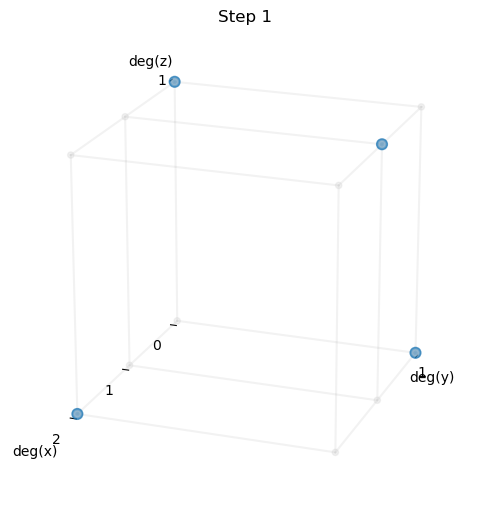


---------------------------------
Spanning the border
span border

segment: Segment(lb=[1 0 0], ub=[2 1 1], endpoint=[array([2, 0, 0]), array([1, 1, 1])])
valid_coordinates: [ True  True  True]
max face points: [[2 1 1]
 [1 0 1]
 [1 1 0]
 [2 1 0]
 [2 0 1]
 [2 0 0]
 [1 1 1]]
at up corner: [2 1 1]
not at up corner: [1 0 1] [1 0 1]
not at up corner: [1 1 0] [1 1 0]
not at up corner: [2 1 0] [2 1 0]
at up corner: [2 0 1]
not at up corner: [2 0 0] [2 0 0]
at up corner: [1 1 1]
new points  [array([1, 0, 1]), array([1, 1, 0]), array([2, 1, 0])]

segment: Segment(lb=[0 1 0], ub=[1 1 1], endpoint=[array([0, 1, 0]), array([1, 1, 1])])
valid_coordinates: [ True False  True]
max face points: [[1 0]
 [1 1]
 [0 1]]
not at up corner: [1 0] [1 1 0]
at up corner: [1 1]
not at up corner: [0 1] [0 1 1]
new points  [array([1, 1, 0]), array([0, 1, 1])]

segment: Segment(lb=[0 0 1], ub=[1 1 1], endpoint=[array([0, 0, 1]), array([1, 1, 1])])
valid_coordinates: [ True  True False]
max face points: [[1 0]
 [1

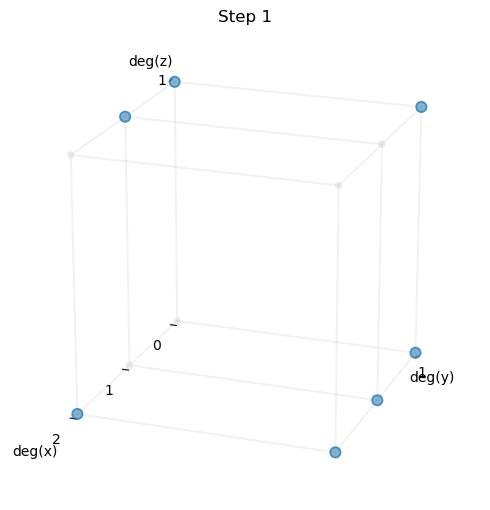

In [595]:
%time
seed = 2
np.random.seed(seed)
import random
random.seed(seed)

ring = PolynomialRing(QQ, ('x', 'y', 'z'), order='degrevlex')
generator = BorderBasisGenerator(ring)

dbounds = [2, 1, 1]
ret = generator.find_random_border(dbounds, max_iters=10)
# Bs = ret['trajectory'] + [ret['border']]
# # plot_borders_3d(dbounds, Bs)
# plot_border_3d(dbounds, ret['endpoints'])
# plot_border_3d(dbounds, ret['border'])

In [129]:
ret['segments']

[Segment(lb=[1 0 0], ub=[1 0 1], endpoint=[array([1, 0, 0]), array([1, 0, 1])]),
 Segment(lb=[0 0 0], ub=[1 1 1], endpoint=[array([0, 1, 0]), array([1, 0, 1])]),
 Segment(lb=[0 0 1], ub=[1 0 1], endpoint=[array([0, 0, 1]), array([1, 0, 1])])]

In [276]:
ret['segments']

[Segment(lb=[0 1 0], ub=[0 3 1], endpoint=[array([0, 3, 0]), array([0, 1, 1])]),
 Segment(lb=[0 0 1], ub=[0 1 2], endpoint=[array([0, 0, 2]), array([0, 1, 1])]),
 Segment(lb=[1 0 0], ub=[2 1 0], endpoint=[array([2, 0, 0]), array([1, 1, 0])]),
 Segment(lb=[0 1 0], ub=[1 1 0], endpoint=[array([0, 1, 0]), array([1, 1, 0])]),
 Segment(lb=[0 0 0], ub=[1 1 1], endpoint=[array([0, 0, 1]), array([1, 1, 0])])]

In [302]:
OB = [ring.monomial(*r) for r in ret['border']]

In [303]:
is_order_ideal(OB)

False

In [240]:
ret['segments']

[Segment(lb=[0 1 0], ub=[0 3 1], endpoint=[array([0, 3, 0]), array([0, 1, 1])]),
 Segment(lb=[0 0 1], ub=[0 1 2], endpoint=[array([0, 0, 2]), array([0, 1, 1])]),
 Segment(lb=[1 0 0], ub=[2 1 0], endpoint=[array([2, 0, 0]), array([1, 1, 0])]),
 Segment(lb=[0 1 0], ub=[1 1 0], endpoint=[array([0, 1, 0]), array([1, 1, 0])]),
 Segment(lb=[0 0 0], ub=[1 1 1], endpoint=[array([0, 0, 1]), array([1, 1, 0])])]

segment picekd up: Segment(lb=[0 0 0], ub=[2 2 2], endpoint=[array([2, 0, 0]), array([0, 2, 0]), array([0, 0, 2])])
new endpoint: [2 1 2]
new segments:
Segment(lb=[2 0 0], ub=[2 1 2], endpoint=[array([2, 0, 0]), array([2, 1, 0]), array([2, 0, 2])])
--- accepted!
Segment(lb=[0 1 0], ub=[2 2 2], endpoint=[array([2, 1, 0]), array([0, 2, 0]), array([0, 1, 2])])
--- accepted!
Segment(lb=[0 0 2], ub=[2 1 2], endpoint=[array([2, 0, 2]), array([0, 1, 2]), array([0, 0, 2])])
--- accepted!
segment picekd up: Segment(lb=[2 0 0], ub=[2 1 2], endpoint=[array([2, 0, 0]), array([2, 1, 0]), array([2, 0, 2])])
--- rejected! [2 0 0]
new endpoint: [2 1 0]
new segments:
Segment(lb=[2 0 0], ub=[2 1 0], endpoint=[array([2, 0, 0]), array([2, 1, 0]), array([2, 0, 0])])
--- rejected! degenerated
--- rejected! on the same street
Segment(lb=[2 1 0], ub=[2 1 0], endpoint=[array([2, 1, 0]), array([2, 1, 0]), array([2, 1, 0])])
--- rejected! degenerated
Segment(lb=[2 0 0], ub=[2 1 2], endpoint=[array([2, 0, 0]), ar

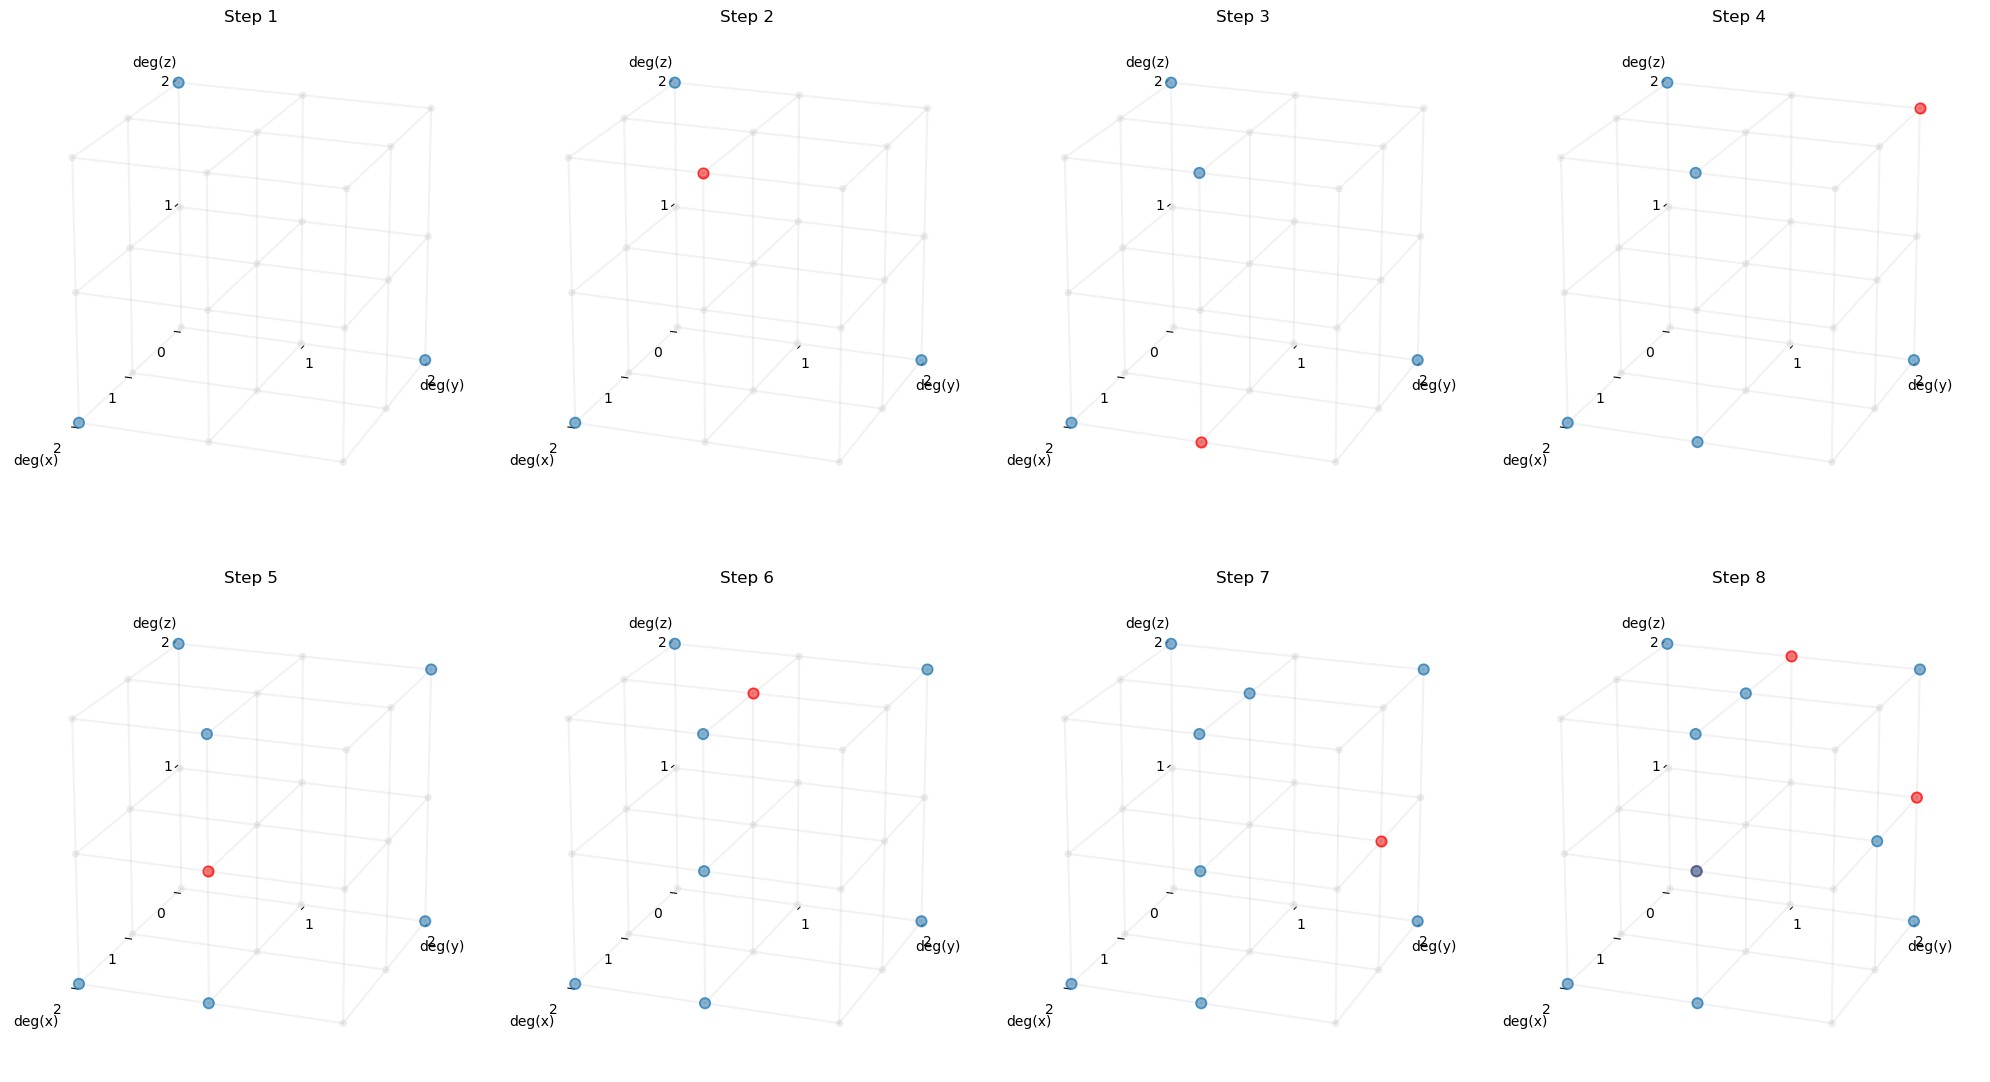

In [22]:
# fix random seed
seed = 5
np.random.seed(seed)
import random
random.seed(seed)


ring = PolynomialRing(QQ, ('x', 'y', 'z'), order='degrevlex')
generator = BorderBasisGenerator(ring)

dbounds = [2, 2, 2]
ret = generator.find_random_preborder(dbounds, max_iters=20)
Bs = ret['trajectory']
B = generator.close_border(Bs[-1])
Bs.append(B)
# # plot_borders(dbounds, Bs)
O = order_from_border([ring.monomial(*e) for e in B], ring)
# print(O)
plot_borders_3d(dbounds, Bs)

In [54]:
ret['segments']

[[array([2, 2, 1]), array([2, 0, 2]), array([1, 0, 1])],
 [array([2, 2, 0]), array([1, 2, 0]), array([2, 2, 2])],
 [array([2, 2, 1]), array([2, 0, 1]), array([0, 1, 1])],
 [array([1, 1, 2]), array([2, 1, 1]), array([0, 1, 2])],
 [array([2, 0, 0]), array([0, 0, 2]), array([2, 1, 1])],
 [array([2, 0, 0]), array([2, 2, 1]), array([2, 1, 2])],
 [array([1, 1, 2]), array([2, 2, 2]), array([2, 1, 0])],
 [array([0, 0, 2]), array([2, 1, 1]), array([0, 1, 2])],
 [array([2, 2, 1]), array([1, 0, 1]), array([1, 0, 2])],
 [array([2, 0, 0]), array([2, 0, 2]), array([2, 1, 2])],
 [array([0, 2, 0]), array([1, 1, 2]), array([1, 2, 2])],
 [array([0, 2, 0]), array([2, 0, 1]), array([0, 1, 1])],
 [array([1, 1, 2]), array([2, 2, 1]), array([1, 0, 2])],
 [array([1, 2, 0]), array([2, 2, 2]), array([2, 1, 0])],
 [array([1, 1, 2]), array([1, 2, 0]), array([2, 1, 0])],
 [array([2, 0, 0]), array([0, 2, 0]), array([2, 0, 1])]]

In [585]:
ret['segments']

[]

In [5]:
import matplotlib.pyplot as plt
import math

def plot_borders(degree_bounds, borders, filename=None):
    aspect_ratio = degree_bounds[0] / degree_bounds[1]
    
    n_plots = len(borders)
    n_cols = int(min(2 / aspect_ratio, n_plots))
    n_rows = math.ceil(n_plots / n_cols)
    
    fig = plt.figure(figsize=(3*n_cols, 2*n_rows))
    
    border_color = '#1f77b4'  # Steel blue
    
    for idx, border in enumerate(borders):
        ax = fig.add_subplot(n_rows, n_cols, idx+1)
        
        # Plot all points up to degree bounds
        points = [(i,j) for i in range(degree_bounds[0] + 1) 
                 for j in range(degree_bounds[1] + 1)]
        x_coords, y_coords = zip(*points)
        ax.scatter(x_coords, y_coords, c='lightgray', s=20, zorder=2)
        
        # Plot border points with blue color
        border_x, border_y = zip(*border)
        if idx == 0:
            ax.scatter(border_x, border_y, c=border_color, s=20, alpha=0.7, zorder=3)
        else:
            n = len(borders[idx-1])
            ax.scatter(border_x[:n], border_y[:n], c=border_color, s=20, alpha=0.7, zorder=3)
            ax.scatter(border_x[n:], border_y[n:], c='red', s=20, alpha=0.7, zorder=3)
        
        # Plot grid (with lower zorder)
        for i in range(degree_bounds[0] + 1):
            ax.axvline(i, color='gray', alpha=0.2, zorder=1)
        for i in range(degree_bounds[1] + 1):
            ax.axhline(i, color='gray', alpha=0.2, zorder=1)
        
        xticks = range(0, degree_bounds[0] + 1, max(1, degree_bounds[0] // 4))
        yticks = range(0, degree_bounds[1] + 1, max(1, degree_bounds[1] // 4))
        
        ax.set_xlabel('deg(x)')
        ax.set_ylabel('deg(y)')
        ax.grid(True, alpha=0.2, zorder=1)
        ax.set_xticks(xticks)
        ax.set_yticks(yticks)
        ax.set_title(f'Step {idx+1}', pad=3)
    
        ax.set_box_aspect(aspect_ratio)
        
    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()

def plot_border(degree_bounds, border, filename=None):
    plot_borders(degree_bounds, [border], filename)

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import numpy as np

def plot_borders_3d(degree_bounds, borders, filename=None):
    n_plots = len(borders)
    n_cols = int(min(4, n_plots))
    n_rows = math.ceil(n_plots / n_cols)
    
    fig = plt.figure(figsize=(5*n_cols, 6*n_rows))
    
    border_color = '#1f77b4'  # Steel blue
    
    for idx, border in enumerate(borders):
        ax = fig.add_subplot(n_rows, n_cols, idx+1, projection='3d')
        
        # グリッド線を追加
        for i in range(degree_bounds[0] + 1):
            for j in range(degree_bounds[1] + 1):
                ax.plot([i, i], [j, j], [0, degree_bounds[2]], 'gray', alpha=0.1)  # 垂直線

        for i in range(degree_bounds[0] + 1):
            for k in range(degree_bounds[2] + 1):
                ax.plot([i, i], [0, degree_bounds[1]], [k, k], 'gray', alpha=0.1)  # y方向の線

        for j in range(degree_bounds[1] + 1):
            for k in range(degree_bounds[2] + 1):
                ax.plot([0, degree_bounds[0]], [j, j], [k, k], 'gray', alpha=0.1)  # x方向の線
        
        # Plot all points up to degree bounds
        points = [(i,j,k) for i in range(degree_bounds[0] + 1) 
                         for j in range(degree_bounds[1] + 1)
                         for k in range(degree_bounds[2] + 1)]
        if points:
            x_coords, y_coords, z_coords = zip(*points)
            ax.scatter(x_coords, y_coords, z_coords, c='lightgray', s=20, alpha=0.3)
        
        # Plot border points with blue color
        border_x, border_y, border_z = zip(*border)
        if idx == 0:
            ax.scatter(border_x, border_y, border_z, c=border_color, s=60, alpha=0.7)
        else:
            n = len(borders[idx-1])
            ax.scatter(border_x[:n], border_y[:n], border_z[:n], c=border_color, s=60, alpha=0.7)
            ax.scatter(border_x[n:], border_y[n:], border_z[n:], c='red', s=60, alpha=0.7)
                
        # Set labels and ticks
        ax.zaxis.set_rotate_label(False)
        ax.set_xlabel('deg(x)')
        ax.set_ylabel('deg(y)')
        ax.set_zlabel('deg(z)', rotation=0)
        
        xticks = range(0, degree_bounds[0] + 1, max(1, degree_bounds[0] // 4))
        yticks = range(1, degree_bounds[1] + 1, max(1, degree_bounds[1] // 4))
        zticks = range(1, degree_bounds[2] + 1, max(1, degree_bounds[2] // 4))
        
        ax.set_xticks(xticks)
        ax.set_yticks(yticks)
        ax.set_zticks(zticks)
        
        ax.set_title(f'Step {idx+1}')
        
        # Set aspect ratio
        ax.set_box_aspect([1,1,1])
        
        # 平面のグリッドと背景色を消す
        ax.grid(False)  # グリッドを消す
        ax.xaxis.pane.fill = False  # x=0平面の塗りつぶしを消す
        ax.yaxis.pane.fill = False  # y=0平面の塗りつぶしを消す
        ax.zaxis.pane.fill = False  # z=0平面の塗りつぶしを消す

        # 平面の枠線も消したい場合
        ax.xaxis.pane.set_edgecolor('none')
        ax.yaxis.pane.set_edgecolor('none')
        ax.zaxis.pane.set_edgecolor('none')
        
        # 視点の設定
        ax.view_init(elev=20, azim=20)  # 標準的な等角投影の角度

        # Adjust view angle for better visibility
        ax.set_xlim(0, degree_bounds[0])  # x軸を反転（奥から手前へ）
        ax.set_ylim(0, degree_bounds[1])  # y軸は右向き
        ax.set_zlim(0, degree_bounds[2])  # z軸は上向き

        ax.xaxis._axinfo['juggled'] = (0,0,0)
        ax.yaxis._axinfo['juggled'] = (1,1,1)
        ax.zaxis._axinfo['juggled'] = (2,2,2)
        # ax.xaxis.set_ticks_position('top')  # x軸を奥に
        # ax.yaxis.set_ticks_position('default')  # y軸を右（奥）に
        # ax.zaxis.set_ticks_position('upper')    # z軸を上（奥）に

    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()

def plot_border_3d(degree_bounds, border, filename=None):
    plot_borders_3d(degree_bounds, [border], filename)

# # 使用例
# if __name__ == "__main__":
    # サンプルデータ
# degree_bounds = (3, 3, 3)
# border = [(1,1,1), (2,1,1), (1,2,1), (1,1,2)]
# plot_border_3d(degree_bounds, border)

In [8]:
OP

NameError: name 'OP' is not defined

In [172]:
BP

[ 125   -8  1/8    8]
[   1    1  -25  -16]
[   0  -16 -1/2    1]
[   5  -32    0   32]
[ 1/4    1   -1  -64]
[   0  -64 -1/8    1]

In [84]:
# get random matrix with entries in ring.base_ring() and ranging from -5 ,5 
M = random_matrix(ring.base_ring(), 3, 3, x=-5, y=5)

TypeError: randomize() got an unexpected keyword argument 'x'

In [ ]:
import numpy as np
# P = np.random.randint(-5, 5, (len(O), 2))

FP = subs(O, P)
is_regular(FP)

True

In [76]:
BP = subs(B, P)
C = np.linalg.lstsq(FP, BP, rcond=None)[0]
C.shape

(6, 4)

In [ ]:
np.linalg.norm(BP - FP @ C)

5.352483649338326e-13